In [1]:
from fairPCA import StreamingFairBlockPCA
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import random
from copy import deepcopy
from tqdm.auto import tqdm

Algo = StreamingFairBlockPCA(
    data_dim=100,
    probability=0.2,
    rank=5,  # effective rank of Sigma_gap
    seed=42,
    eps=.3,
    mu_scale=3,
    max_cov_eig0=4,
    max_cov_eig1=3,
)

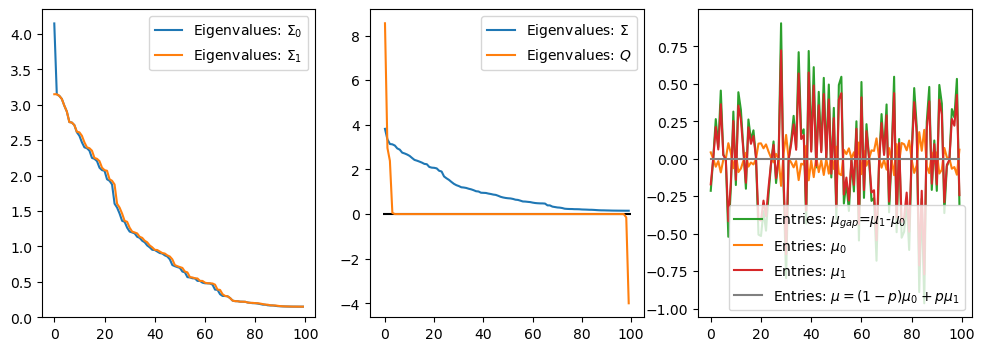

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

w0, _ = np.linalg.eigh(Algo.Sigma0)
w1, _ = np.linalg.eigh(Algo.Sigma1)
w, _ = np.linalg.eigh(Algo.Sigma)
wg, _ = np.linalg.eigh(Algo.Sigma_gap + np.outer(Algo.mu1, Algo.mu1) - np.outer(Algo.mu0, Algo.mu0))

ax[0].plot(w0[::-1], label='Eigenvalues: $\\Sigma_0$')
ax[0].plot(w1[::-1], label='Eigenvalues: $\\Sigma_1$')
ax[0].legend()
ax[0].set_ylim(bottom=0)
ax[1].hlines(0, -1, Algo.d, color='k')
ax[1].plot(w[::-1], label='Eigenvalues: $\\Sigma$')
ax[1].plot(wg[::-1],label='Eigenvalues: $Q$')
# ax[1].set_xlim(-1, Algo.d)
ax[1].legend()
ax[2].plot(Algo.mu_gap, c='tab:green', label='Entries: $\mu_{gap}$=$\mu_1$-$\mu_0$')
ax[2].plot(Algo.mu0, c='tab:orange', label='Entries: $\mu_0$')
ax[2].plot(Algo.mu1, c='tab:red', label='Entries: $\mu_1$')
ax[2].plot(Algo.mu, c='gray', label='Entries: $\mu=(1-p)\mu_0 + p\mu_1$')
ax[2].legend()

In [3]:
n_samples = 1000
Data = [[], []]
for _ in range(n_samples):
    s, data = Algo.sample()
    Data[s].append(data)


/Users/hanseul_jo/Desktop/fair-streaming-pca/synthetic_fair_streaming_pca/fairPCA.py:455: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = np.random.multivariate_normal(mean=eval(f"self.mu{s}"), cov=eval(f"self.Sigma{s}"))


## Offline Training (Knowing true mean & covariances)

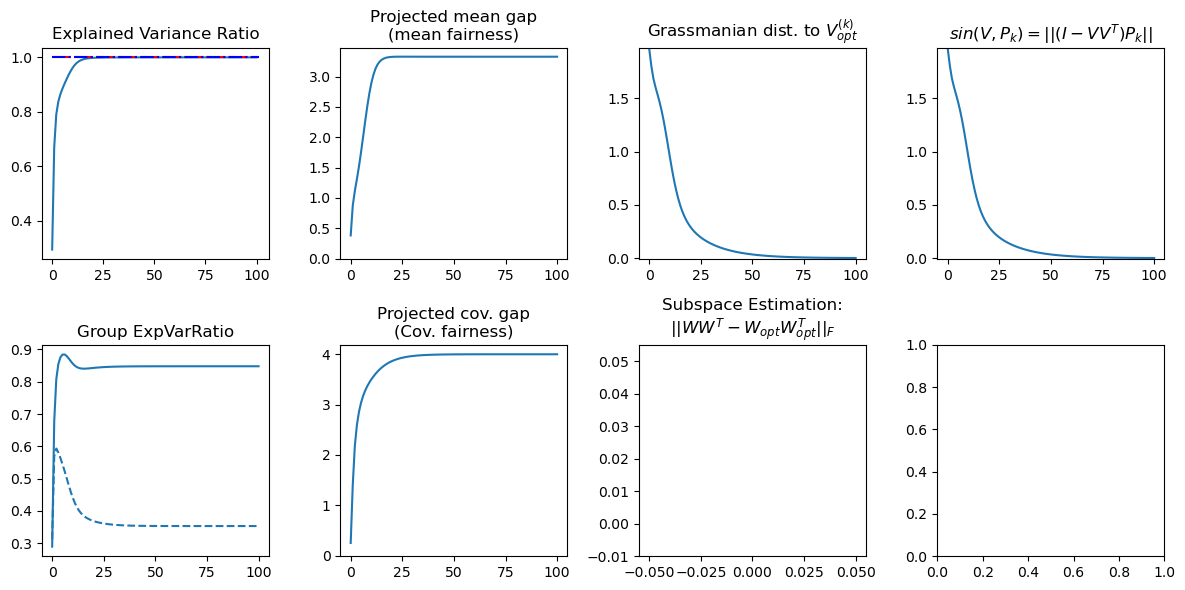

In [4]:
n_iter = 100
Algo.offline_train(
    target_dim=2,
    rank=1,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    lr=1,
    pca_optimization='pm',
    constraint='vanilla',
    seed=0,
)
fig, axes = Algo.plot_buffer(save=None);  # semicolon
# Algo.plot_buffer(save=None, fig=fig, axes=axes); 
# fig

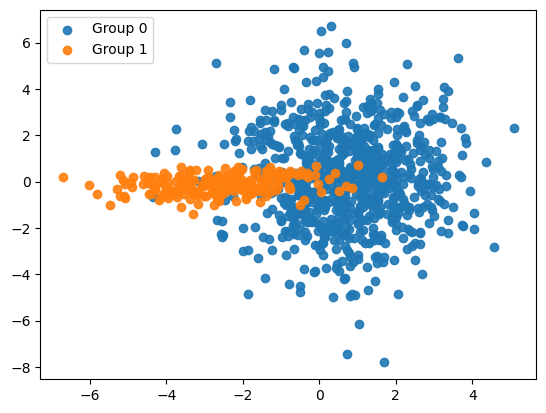

In [5]:
X_vanilla, Y_vanilla = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_vanilla[s].append(x)
        Y_vanilla[s].append(y)

plt.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=0.9)
plt.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=0.9)
plt.legend()
# plt.xlim(-12,12)
# plt.ylim(-12,12)

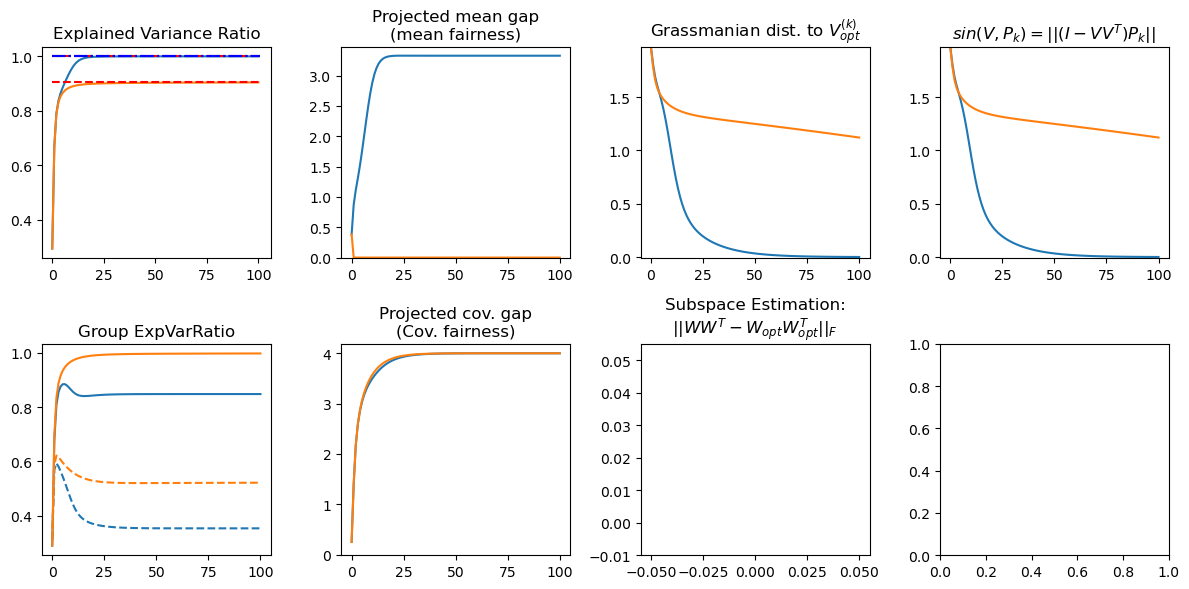

In [6]:
Algo.offline_train(
    target_dim=2,
    rank=1,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    lr=1,
    pca_optimization='pm',
    constraint='mean',
    seed=0,
)
# fig, axes = Algo.plot_buffer(save=None); 
Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

(-12.0, 12.0)

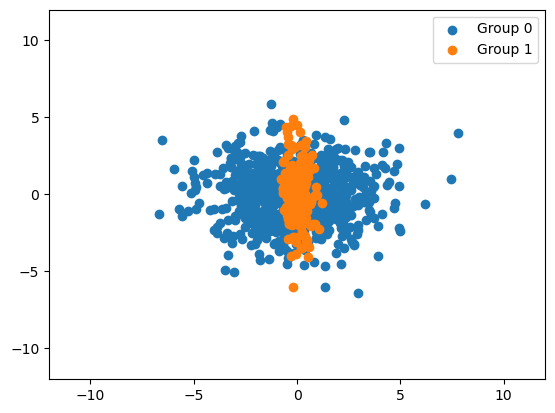

In [7]:
X_mean, Y_mean = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_mean[s].append(x)
        Y_mean[s].append(y)


plt.scatter(X_mean[0],Y_mean[0], label='Group 0')
plt.scatter(X_mean[1],Y_mean[1], label='Group 1')
plt.legend()
plt.xlim(-12,12)
plt.ylim(-12,12)

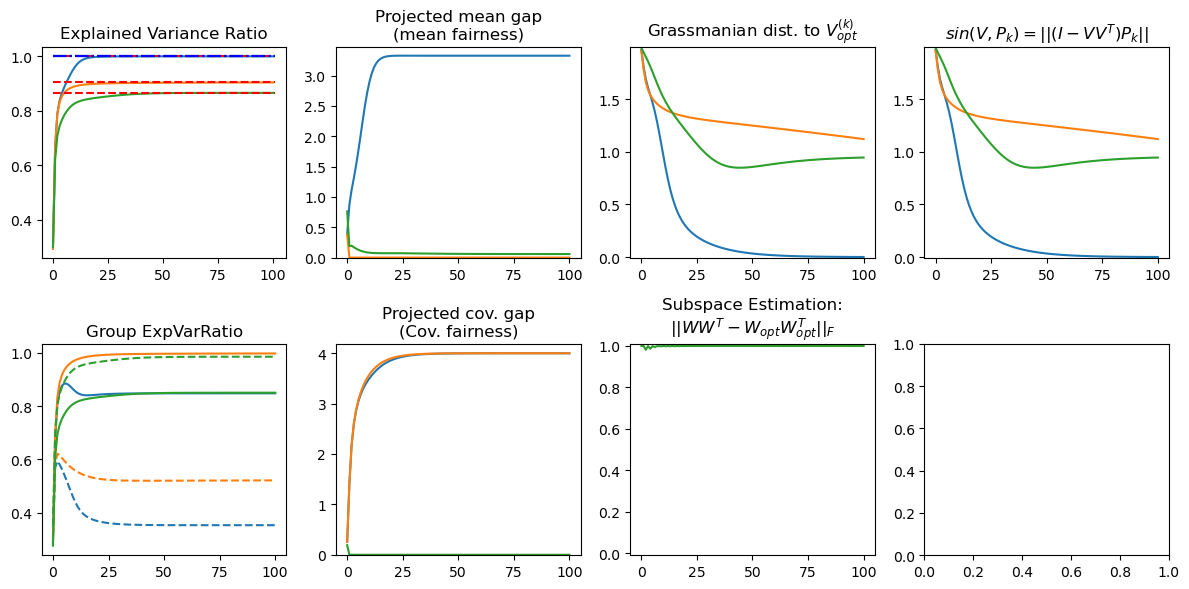

In [8]:
n_iter=100
Algo.offline_train(
    target_dim=2,
    rank=10,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    lr=1,
    pca_optimization='pm',
    constraint='all',
    seed=0,
)
# fig, axes = Algo.plot_buffer(save=None); 
Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

(-12.0, 12.0)

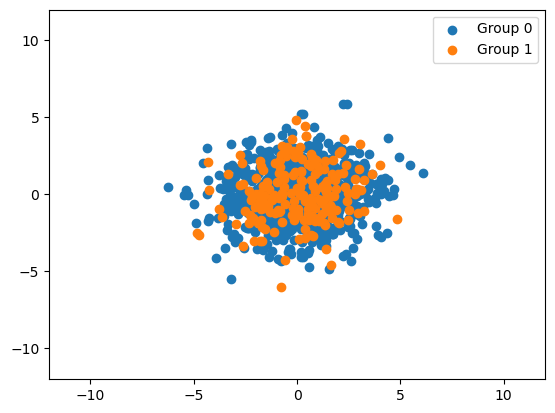

In [9]:
X_all, Y_all = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_all[s].append(x)
        Y_all[s].append(y)


plt.scatter(X_all[0],Y_all[0], label='Group 0')
plt.scatter(X_all[1],Y_all[1], label='Group 1')
plt.legend()
plt.xlim(-12,12)
plt.ylim(-12,12)

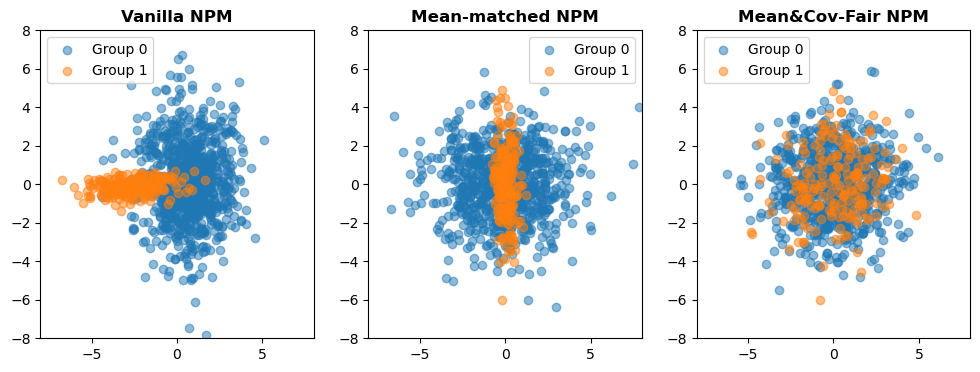

In [10]:
# Scatter plots in one figure
fig_all, axes_all = plt.subplots(1,3, figsize=(12,4))

# axes_all[0] = plt.subplot(141, projection='3d')
# ax = axes_all[0]
# X0,Y0,Z0 = zip(*Data[0])
# X1,Y1,Z1 = zip(*Data[1])
# ax.scatter(X0,Y0,Z0, label='Group 0')
# ax.scatter(X1,Y1,Z1, label='Group 1')
alpha=0.5

ax = axes_all[0]
ax.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=alpha)
ax.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_title('Vanilla NPM', weight='bold')

ax = axes_all[1]
ax.scatter(X_mean[0],Y_mean[0], label='Group 0', alpha=alpha)
ax.scatter(X_mean[1],Y_mean[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_title('Mean-matched NPM', weight='bold')

ax = axes_all[2]
ax.scatter(X_all[0],Y_all[0], label='Group 0', alpha=alpha)
ax.scatter(X_all[1],Y_all[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_title('Mean&Cov-Fair NPM', weight='bold')
fig_all.savefig('comparison_offline.pdf')

## Streaming - Fair PCA

  0%|          | 0/50 [00:00<?, ?it/s]

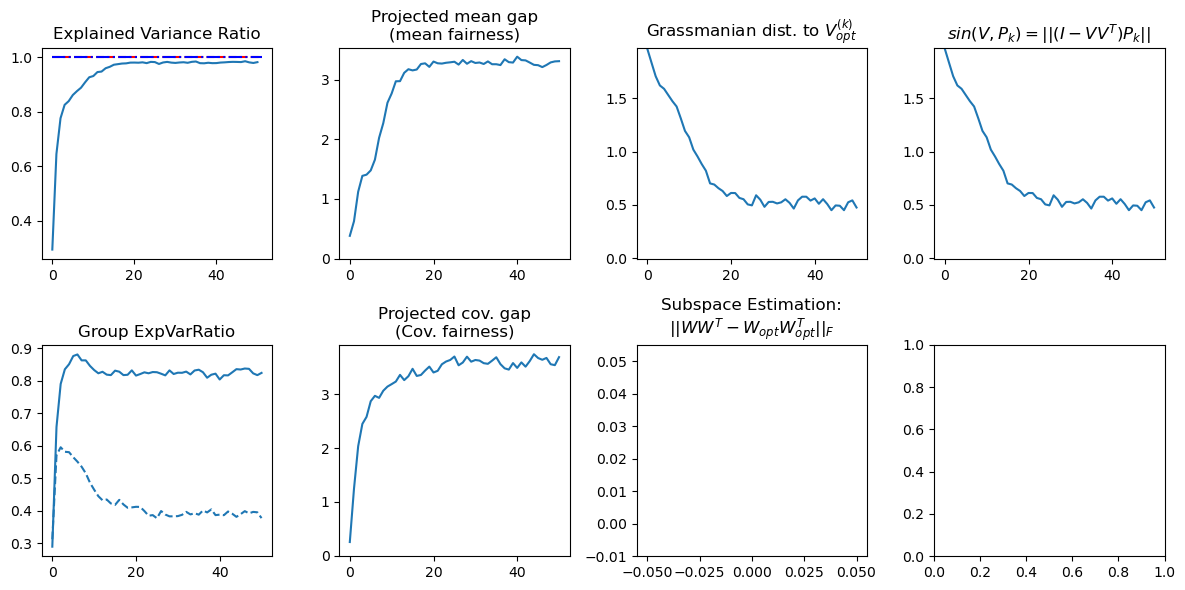

In [12]:
n_iter = 50
Algo_vanilla = deepcopy(Algo)
Algo_vanilla.train(
    target_dim=2,
    rank=0,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    batch_size_subspace=None,
    batch_size_pca=1000,
    constraint='vanilla', # unfair
    subspace_optimization=None,
    pca_optimization='npm',
    lr_pca=None,
    seed=0,
    verbose=True,
    # lr_scheduler=lambda t: 0.998**(t-1)
)
fig, axes = Algo_vanilla.plot_buffer(save=None);  # semicolon
# Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

(-5.0, 5.0)

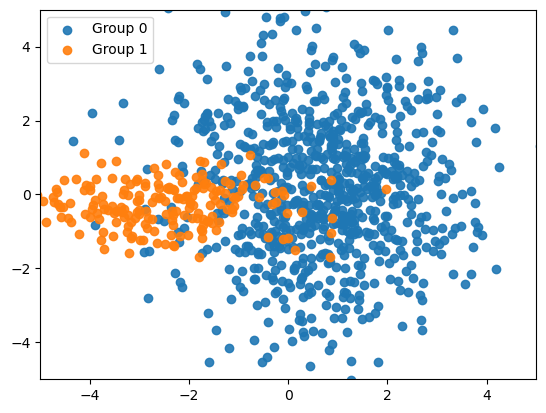

In [13]:
X_vanilla, Y_vanilla = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo_vanilla.transform_low_dimension(data)
        X_vanilla[s].append(x)
        Y_vanilla[s].append(y)

plt.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=0.9)
plt.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=0.9)
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

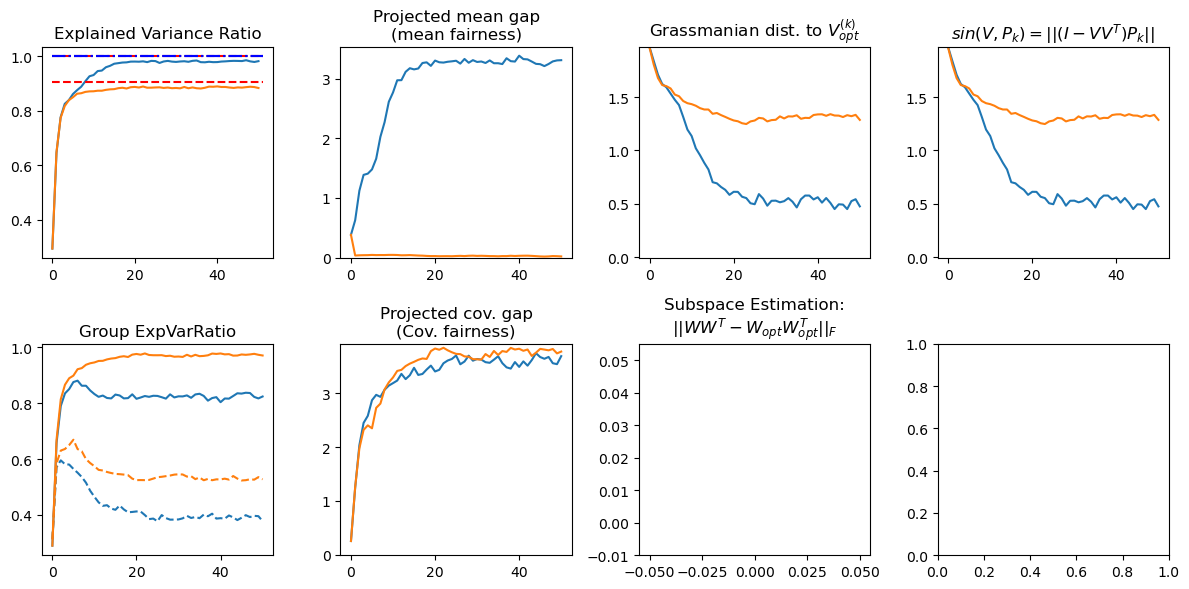

In [14]:
Algo_mean = deepcopy(Algo)
Algo_mean.train(
    target_dim=2,
    rank=0,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    batch_size_subspace=1000,
    batch_size_pca=1000,
    constraint='mean', # unfair
    subspace_optimization='npm',
    pca_optimization='npm',
    lr_pca=None,
    seed=0,
    verbose=True,
    # lr_scheduler=lambda t: 0.998**(t-1)
)
# fig, axes = Algo.plot_buffer(save=None);  # semicolon
Algo_mean.plot_buffer(save=None, fig=fig, axes=axes); fig

(-5.0, 5.0)

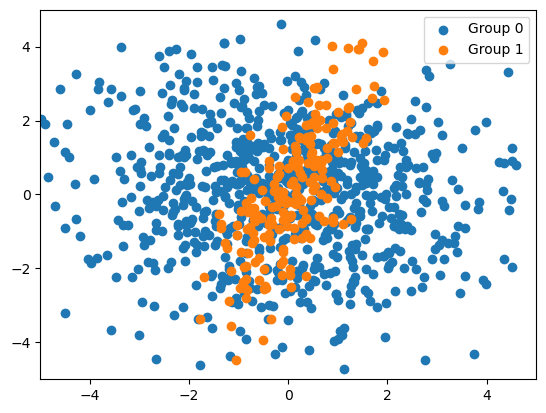

In [15]:
X_mean, Y_mean = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo_mean.transform_low_dimension(data)
        X_mean[s].append(x)
        Y_mean[s].append(y)


plt.scatter(X_mean[0],Y_mean[0], label='Group 0')
plt.scatter(X_mean[1],Y_mean[1], label='Group 1')
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

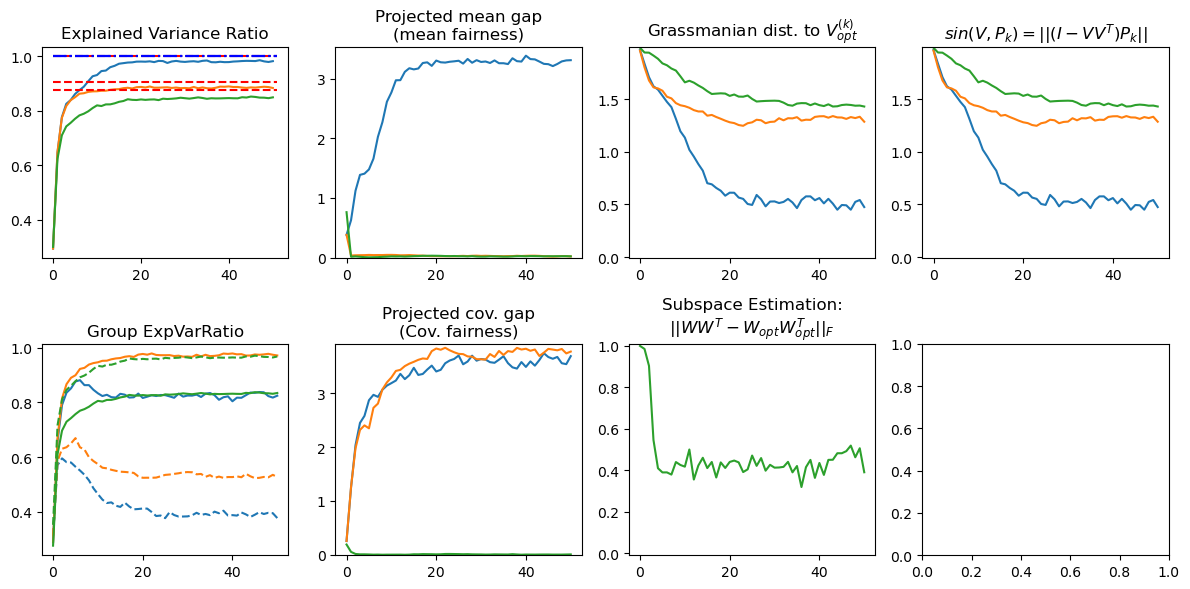

In [16]:
Algo_all = deepcopy(Algo)
Algo_all.train(
    target_dim=2,
    rank=3,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    batch_size_subspace=1000,
    batch_size_pca=1000,
    constraint='all',
    subspace_optimization='npm',
    pca_optimization='npm',
    lr_pca=None,
    seed=0,
    verbose=True,
    # lr_scheduler=lambda t: 0.998**(t-1)
)
# fig, axes = Algo.plot_buffer(save=None);  # semicolon
Algo_all.plot_buffer(save=None, fig=fig, axes=axes); fig

(-5.0, 5.0)

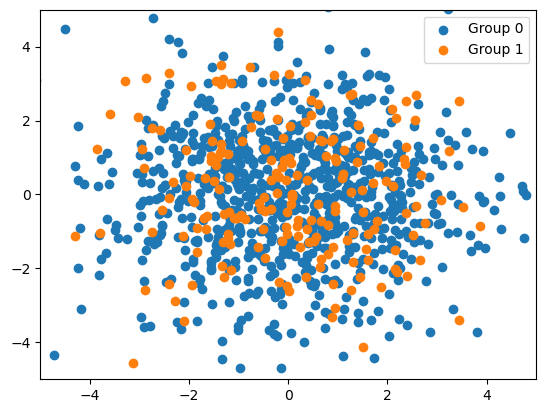

In [17]:
X_all, Y_all = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo_all.transform_low_dimension(data)
        X_all[s].append(x)
        Y_all[s].append(y)


plt.scatter(X_all[0],Y_all[0], label='Group 0')
plt.scatter(X_all[1],Y_all[1], label='Group 1')
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)

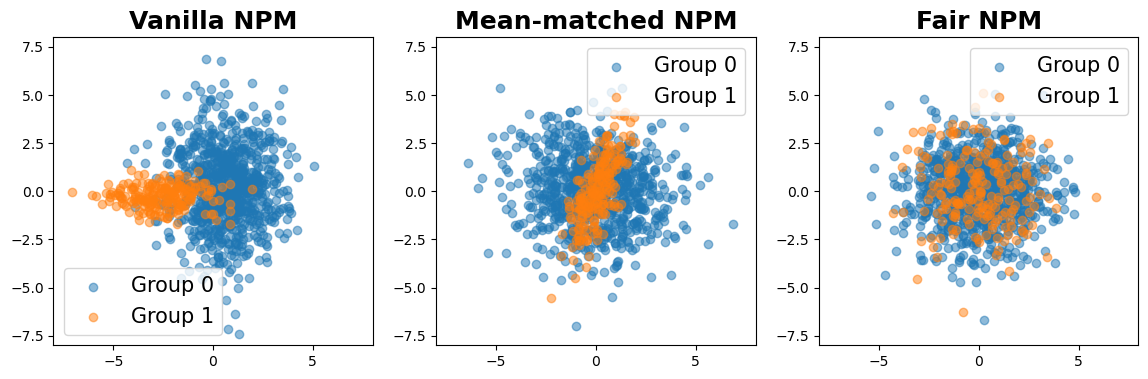

In [18]:
# Scatter plots in one figure
fig_all, axes_all = plt.subplots(1,3, figsize=(14,4))
plt.rcParams['font.size'] = 15

# axes_all[0] = plt.subplot(141, projection='3d')
# ax = axes_all[0]
# X0,Y0,Z0 = zip(*Data[0])
# X1,Y1,Z1 = zip(*Data[1])
# ax.scatter(X0,Y0,Z0, label='Group 0')
# ax.scatter(X1,Y1,Z1, label='Group 1')
alpha=0.5

ax = axes_all[0]
ax.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=alpha)
ax.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=alpha)
# ax.scatter(np.stack(X_vanilla[0]).mean(0), np.stack(Y_vanilla[0]).mean(0), marker='*', s=100, c='yellow')
# ax.scatter(np.stack(X_vanilla[1]).mean(0), np.stack(Y_vanilla[1]).mean(0), marker='*', s=100, c='lightgreen')
ax.legend()
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_title('Vanilla NPM', weight='bold')

ax = axes_all[1]
ax.scatter(X_mean[0],Y_mean[0], label='Group 0', alpha=alpha)
ax.scatter(X_mean[1],Y_mean[1], label='Group 1', alpha=alpha)
# ax.scatter(np.stack(X_mean[0]).mean(0), np.stack(Y_mean[0]).mean(0), marker='*', s=100, c='yellow')
# ax.scatter(np.stack(X_mean[1]).mean(0), np.stack(Y_mean[1]).mean(0), marker='*', s=100, c='lightgreen')
ax.legend()
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_title('Mean-matched NPM', weight='bold')

ax = axes_all[2]
ax.scatter(X_all[0],Y_all[0], label='Group 0', alpha=alpha)
ax.scatter(X_all[1],Y_all[1], label='Group 1', alpha=alpha)
# ax.scatter(np.stack(X_all[0]).mean(0), np.stack(Y_all[0]).mean(0), marker='*', s=100, c='yellow')
# ax.scatter(np.stack(X_all[1]).mean(0), np.stack(Y_all[1]).mean(0), marker='*', s=100, c='lightgreen')
ax.legend()
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_title('Fair NPM', weight='bold')
fig_all.savefig('comparison_synthetic_streaming.pdf')